In [88]:
from langchain_openai import ChatOpenAI

from dotenv import load_dotenv
import os
load_dotenv()

if os.environ['OPENAI_API_KEY']:
    print("OpenAI API Key is set.")
else:
    raise ValueError("OpenAI API Key is not set.")

OpenAI API Key is set.


In [89]:
llm = ChatOpenAI(model="gpt-5-nano")
llm.invoke("I want to know the meaning of water").content


'Water can mean a few related things, so here are the main angles:\n\n- Scientific meaning\n  - Water is a chemical substance with the formula H2O: two hydrogen atoms bonded to one oxygen atom.\n  - It is a liquid at most everyday temperatures and pressures, but it can be solid (ice) or gas (steam).\n  - It’s a polar molecule, which makes it a great solvent and gives water many unique properties (cohesion, surface tension, high heat capacity, density changes when it freezes).\n\n- Properties and basics\n  - It has a high capacity to store heat, helping regulate climate and keep organisms cool or warm.\n  - It expands when it freezes, so ice floats on liquid water.\n  - It exists in all three states on Earth at various places and times (in air, on the ground, underground).\n\n- Importance to life and daily use\n  - Water is essential for all known forms of life; it transports nutrients, supports chemical reactions, and helps regulate body temperature.\n  - We use it for drinking, cookin

### **LLM Pydantic Schema**

In [90]:
from pydantic import BaseModel, Field
from typing import Literal

class llm_schema(BaseModel):
    category: Literal['insta', 'twitter', 'linkedin'] = Field(..., description="Category of the post to generate")
    topic: str = Field(..., description="Topic of the post to generate")

In [91]:
llm_with_schema = llm.with_structured_output(llm_schema)

In [92]:
llm_with_schema.invoke("I want to generate a post for twitter about AI").category

'twitter'

### **State Schema**

In [93]:
from typing import TypedDict, List

class graph_schema(TypedDict):
    
    input: str
    topic: str
    post: str
    category: str

In [94]:
def decider_node(state: graph_schema) -> graph_schema:

    # Extract the input from the state
    user_input = state['input']

    # Passing the user input to the LLM to decide the category of the post to generate
    response = llm_with_schema.invoke(user_input) # Pydantic Object
    category = response.category # Extracting the category from the Pydantic Object
    topic = response.topic # Extracting the topic from the Pydantic Object

    # Update the state with the decided category and topic
    state['category'] = category
    state['topic'] = topic

    return state


def create_post_insta(state: graph_schema) -> graph_schema:
    

    # Extract the topic from the state
    topic = state['topic']

    # Passing the topic to the LLM to generate an Instagram post
    post = llm.invoke(f"Write an Instagram post about {topic}. Keep the tone casual and engaging.").content

    # Update the state with the generated post
    state['post'] = post

    return {'post' : post}

def create_post_twitter(state: graph_schema) -> graph_schema:
    

    # Extract the topic from the state
    topic = state['topic']

    # Passing the topic to the LLM to generate a Twitter post
    post = llm.invoke(f"Write a Twitter post about {topic}. Keep the tone quick").content

    # Update the state with the generated post
    state['post'] = post

    return {'post' : post}


def create_post_linkedin(state: graph_schema) -> graph_schema:
    

    # Extract the topic from the state
    topic = state['topic']

    # Passing the topic to the LLM to generate a LinkedIn post
    post = llm.invoke(f"Write a LinkedIn post about {topic}. Keep the tone professional and informative.").content

    # Update the state with the generated post
    state['post'] = post

    return {'post' : post}


In [95]:
def condition(state: graph_schema) -> str:

    category = state['category']

    if category == 'insta':
        return 'create_insta'
    elif category == 'twitter':
        return 'create_twitter'
    elif category == 'linkedin':
        return 'create_linkedin'
    else:
        raise ValueError("Invalid category")



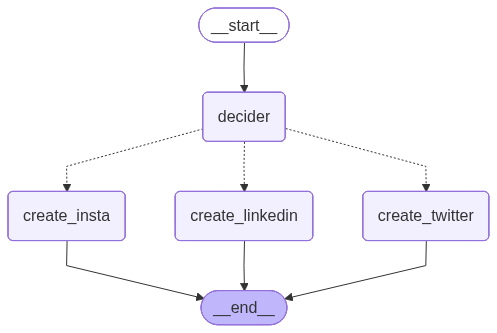

In [96]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(graph_schema)

graph.add_node("decider", decider_node)
graph.add_node("create_insta", create_post_insta)
graph.add_node("create_twitter", create_post_twitter)
graph.add_node("create_linkedin", create_post_linkedin)


graph.add_edge(START, "decider")
graph.add_conditional_edges("decider",condition,{
    'create_insta': "create_insta",
    'create_twitter': "create_twitter",
    'create_linkedin': "create_linkedin"
})

graph.add_edge("create_insta", END)
graph.add_edge("create_twitter", END)
graph.add_edge("create_linkedin", END) 


route_graph = graph.compile()


from IPython.display import Image, display

# You could see the errors with the below command
Image(route_graph.get_graph().draw_mermaid_png())

In [97]:
route_graph.invoke({
    "input": "I want to generate a post for twitter about AI",
    "topic":"",
    "category":"",
    "post":""
})

{'input': 'I want to generate a post for twitter about AI',
 'topic': 'AI',
 'post': 'AI is changing almost everything—fast. Learn, adapt, and stay human. #AI #Tech',
 'category': 'twitter'}